# What is this notebook about?

This notebook will guide us through the process of the TEC variation calculation as it is perfromed at SIMuRG. The research that asesses the performance of different filtration method provided here:

> Maletckii, B.; Yasyukevich, Y.; Vesnin, A. Wave Signatures in Total Electron Content Variations: Filtering Problems. Remote Sens. 2020, 12, 1340.

In this notebook will just focus on the implementation the fullstack processing including RINEX reading etc will be in separate notebook. Here we make assumption: **TEC series already available**. In the end of the notebook you will be able to obtain TEC variations for arbitrary **time series given with uniform timestep** which is hard constraint for method used below.


In [88]:
import datetime
import warnings
from scipy.interpolate import UnivariateSpline
import numpy as np
from numpy.typing import NDArray

class SeriesTooShortError(Exception):
    def __init__(self):
        super().__init__("Series too short to be filtered with given window")

def cma(series: list, window: int) -> NDArray:
    """Central moving average"""
    if window > len(series):
        raise SeriesTooShortError()

    if window % 2 == 0:
        window += 1
        msg = "Window should be odd; window = %d is used" % window
        warnings.warn(msg)

    smoothed = np.zeros(len(series))
    count = len(series)
    half_window = window // 2
    smoothed[0] = series[0]
    smoothed[-1] = series[-1]
    for i in range(1, count - 1):
        mean = 0.0
        active_half_window = half_window
        if i < half_window:
            active_half_window = i
        elif (count - 1 - i) < half_window:
            active_half_window = (count - 1 - i)
        mean = np.sum(series[i - active_half_window: i + active_half_window + 1])
        smoothed[i] = mean / (active_half_window * 2 + 1)
    return smoothed

def cma_filter(series, window_min, window_max):
    """Filter data series using central moving average."""
    data = series
    if window_min > 0:
        data = cma(data, window_min)
    trend = cma(data, window_max)
    return data-trend

def spline_detrend(data, sm_f = 8):
    """
    Takes data of raw TEC and return detrend TEC
    
    Parameters
    ----------
    :param data: numpy array or list
        Raw TEC,len of data must be more then 3
    :param sm_f: int
        smoothing factor of spline
    ----------
    Returns numpy array: TEC without trend
    """
    if len(data) > 3:
        x = np.arange(len(data))
        spl = UnivariateSpline(x, data)
        #spl.set_smoothing_factor(sm_f)
        dif_spl = np.zeros(len(data))
        for j in range(len(data)):
            dif_spl[j] = data[j] - spl(x[j])
        return dif_spl
    else:
        return data
    
def spline_filter(series, window_min, window_max):
    """
    Takes data of raw TEC and filtring it using central moving average 
    and spline detrending.
    Parameters
    ----------    
    :param data: numpy array or list
    Raw TEC,len of data must be more then 3
    window_min : int
        smoothing window
    window_max : int
        trending window
    ----------
    Returns 
    numpy array: filtered series 
    """
    data = spline_detrend(series)
    return cma_filter(data, window_min, window_max)


# Sample data

Here we use data for one arc from 01:01 to 05:35.30 on 2025.04.15 from IRKJ station. Data could be retrieved from SIMURG using [query page](https://simurg.space/create_series) or loaded manually from RINEX files source.

In [89]:
import datetime 

times = []
start = datetime.datetime(2025, 4, 15, 1, 1, tzinfo=datetime.timezone.utc)
end = datetime.datetime(2025, 4, 15, 5, 35, 30, tzinfo=datetime.timezone.utc)
current = start
while current <= end:
    times.append(current)
    current = current + datetime.timedelta(seconds=30)

tecs = [-1.705, -2.5916, -3.2795, -3.9954, -4.6285, -5.5285, -6.2703, -6.8605, -7.5848, -8.1331, 
-8.77, -9.3297, -9.7583, -10.0463, -10.403, -10.5418, -10.8724, -11.1013, -11.3307, -11.5952, 
-11.7996, -12.1855, -12.2648, -12.6115, -12.9077, -13.184, -13.3425, -13.5536, -13.6055, -13.8268, 
-14.0116, -14.1964, -14.5107, -14.6626, -14.9341, -15.21, -15.4462, -15.8648, -15.9815, -16.2749, 
-16.4514, -16.7606, -16.905, -17.3436, -17.524, -17.8522, -18.0856, -18.4019, -18.6888, -19.0597, 
-19.3838, -19.6836, -20.034, -20.4169, -20.7379, -21.1488, -21.3659, -21.6027, -21.9178, -22.2933, 
-22.4907, -22.8592, -22.967, -23.0742, -23.28, -23.6497, -23.8065, -24.007, -24.2474, -24.3424, 
-24.616, -24.9204, -25.2026, -25.4851, -25.7838, -26.1317, -26.3787, -26.5842, -26.8186, -27.1677, 
-27.4142, -27.9339, -28.1984, -28.537, -28.9385, -29.3104, -29.6463, -30.0685, -30.385, -30.7794, 
-31.0282, -31.3826, -31.7162, -31.9828, -32.3279, -32.742, -33.107, -33.4001, -33.8246, -34.0426, 
-34.4509, -34.6556, -34.927, -35.2586, -35.5987, -35.7651, -36.0105, -36.2496, -36.4546, -36.73, 
-36.8896, -37.1672, -37.3426, -37.5241, -37.6512, -37.8377, -38.0464, -38.2179, -38.4019, -38.5206, 
-38.6956, -38.8139, -38.9135, -39.1797, -39.3954, -39.6105, -39.8289, -39.9558, -40.1362, -40.3018, 
-40.4353, -40.612, -40.8047, -40.9534, -41.0894, -41.2117, -41.3727, -41.5035, -41.7013, -41.8265, 
-42.0016, -42.1848, -42.3081, -42.4707, -42.6332, -42.7886, -42.917, -43.1009, -43.23, -43.3649, 
-43.5142, -43.6704, -43.8212, -43.9312, -44.0609, -44.1775, -44.2864, -44.3736, -44.4672, -44.5977, 
-44.6768, -44.759, -44.8579, -44.9553, -45.0407, -45.1079, -45.1883, -45.2884, -45.3598, -45.4508, 
-45.527, -45.6306, -45.7172, -45.7675, -45.8976, -45.969, -46.0446, -46.0888, -46.1684, -46.2391, 
-46.3355, -46.4025, -46.4901, -46.5567, -46.629, -46.7338, -46.7753, -46.8659, -46.9397, -47.0492, 
-47.0969, -47.1489, -47.2339, -47.304, -47.3596, -47.459, -47.5083, -47.5936, -47.6488, -47.7096, 
-47.7875, -47.8333, -47.8939, -47.9325, -47.9697, -48.0064, -48.0399, -48.0593, -48.096, -48.1156, 
-48.1162, -48.1471, -48.1502, -48.1387, -48.1625, -48.158, -48.1787, -48.1802, -48.1603, -48.1929, 
-48.1791, -48.1946, -48.2119, -48.2366, -48.2705, -48.2809, -48.3218, -48.402, -48.4422, -48.5394, 
-48.595, -48.7079, -48.8075, -48.8927, -48.9839, -49.0784, -49.1444, -49.2186, -49.2621, -49.3186, 
-49.3312, -49.3875, -49.4121, -49.4448, -49.472, -49.5028, -49.5223, -49.547, -49.5293, -49.538, 
-49.5724, -49.5499, -49.5667, -49.5649, -49.5665, -49.5342, -49.4814, -49.438, -49.3998, -49.3759, 
-49.335, -49.2891, -49.2639, -49.2465, -49.2526, -49.241, -49.2509, -49.2609, -49.305, -49.31, 
-49.3467, -49.369, -49.3852, -49.4254, -49.4006, -49.429, -49.4158, -49.458, -49.4837, -49.4943, 
-49.4769, -49.4679, -49.4385, -49.4399, -49.4348, -49.4329, -49.4456, -49.4179, -49.4372, -49.4174, 
-49.4086, -49.4092, -49.417, -49.3868, -49.4164, -49.383, -49.3576, -49.3718, -49.3259, -49.3308, 
-49.2789, -49.2484, -49.2326, -49.2321, -49.2148, -49.1721, -49.1573, -49.1296, -49.1227, -49.0906, 
-49.0695, -49.0326, -49.0009, -48.9842, -48.9529, -48.9353, -48.9214, -48.8733, -48.8749, -48.8507, 
-48.8656, -48.8493, -48.8796, -48.8596, -48.8837, -48.9009, -48.9051, -48.9287, -48.9383, -48.9367, 
-48.9419, -48.9266, -48.9375, -48.8932, -48.8724, -48.8508, -48.8024, -48.7454, -48.6948, -48.6339, 
-48.5744, -48.5172, -48.4421, -48.3686, -48.3139, -48.2408, -48.1678, -48.0994, -48.0265, -47.9802, 
-47.8906, -47.8142, -47.7243, -47.6476, -47.5961, -47.5006, -47.4314, -47.3576, -47.286, -47.1965, 
-47.1519, -47.0751, -47.0243, -46.9347, -46.8717, -46.7952, -46.7453, -46.6511, -46.5835, -46.5186, 
-46.4359, -46.3754, -46.2907, -46.2044, -46.1248, -46.0388, -45.9539, -45.8749, -45.8, -45.7018, 
-45.6012, -45.4911, -45.4136, -45.3246, -45.2039, -45.0974, -44.992, -44.8895, -44.7712, -44.6761, 
-44.5268, -44.4215, -44.3167, -44.1877, -44.1195, -44.0221, -43.9065, -43.8027, -43.6937, -43.6137, 
-43.5182, -43.4794, -43.3483, -43.3157, -43.2377, -43.1783, -43.1321, -43.1183, -43.0684, -43.0153, 
-42.9456, -42.8864, -42.8653, -42.7529, -42.6769, -42.5724, -42.4954, -42.4385, -42.3312, -42.2104, 
-42.0776, -41.9648, -41.8687, -41.7259, -41.632, -41.4948, -41.3303, -41.2009, -41.0275, -40.9021, 
-40.7328, -40.6039, -40.4781, -40.3172, -40.1984, -40.0385, -39.9086, -39.7845, -39.6166, -39.4667, 
-39.3298, -39.1378, -38.9973, -38.8545, -38.6189, -38.5125, -38.3017, -38.0991, -37.9077, -37.7118, 
-37.5349, -37.304, -37.113, -36.8743, -36.7085, -36.4707, -36.2764, -36.0782, -35.9025, -35.5922, 
-35.4764, -35.2706, -35.0346, -34.8776, -34.6536, -34.4368, -34.2769, -34.0552, -33.8833, -33.6861, 
-33.5179, -33.2925, -33.0764, -32.8476, -32.6517, -32.4873, -32.2624, -32.1511, -31.8949, -31.708, 
-31.5064, -31.3247, -31.1021, -30.9091, -30.7829, -30.5105, -30.3326, -30.1677, -29.9565, -29.7747, 
-29.5563, -29.3446, -29.197, -28.9966, -28.7856, -28.5923, -28.4278, -28.1792, -27.9754, -27.8418, 
-27.6302, -27.3644, -27.0736, -26.9852, -26.7428, -26.4478, -26.2558, -26.0609, -25.8676, -25.5431, 
-25.4026, -25.0516, -24.8988, -24.5875, -24.4252, -24.1708, -23.9405, -23.6535, -23.3535, -23.2005, 
-23.0641, -22.8688, -22.5216, -22.2613, -21.9953, -21.7635, -21.4635, -21.2561, -20.8689, -20.6034, 
-20.269, -20.063, -19.7316, -19.4517, -19.2097, -18.8841, -18.6287, -18.4269, -18.1905, -17.8674, 
-17.5729, -17.2693, -16.8941, -16.6036, -16.3975, -16.0534, -15.7707, -15.4383, -15.1634, -14.8774]


# Calculate and plot TEC variations

In [90]:
# window must be integer counts per time window  + 1 to be odd and have center index
# if window 10 minutes and date with 30 sec (0.5 minute) timestep then 10 / 0.5 = 20
variations_20_60 = spline_filter(tecs, 121, 241) 
variations_10_20 = spline_filter(tecs, 21, 41) 
variations_2_10 = spline_filter(tecs, 5, 21) 
detrend = spline_detrend(tecs)

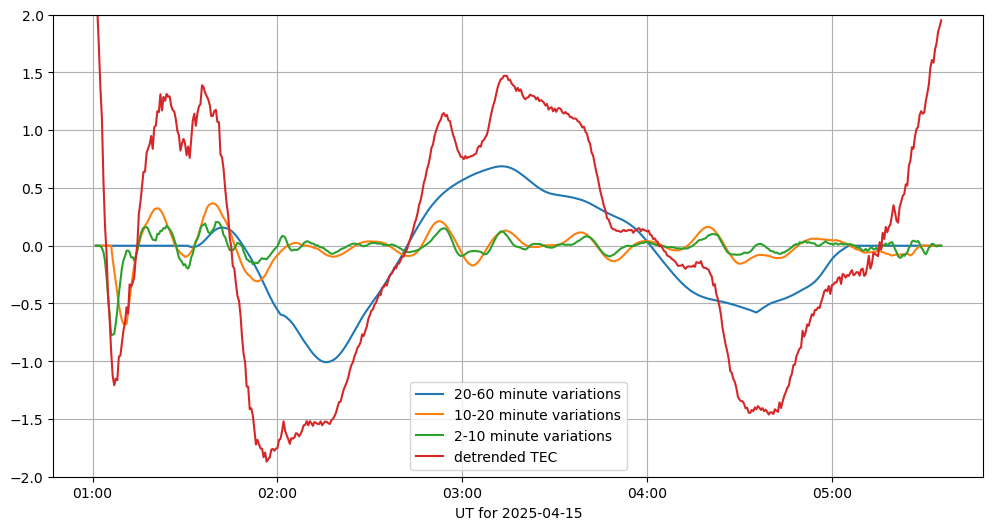

In [91]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
ax.plot(times, variations_20_60, label = "20-60 minute variations")
ax.plot(times, variations_10_20, label = "10-20 minute variations")
ax.plot(times, variations_2_10, label = "2-10 minute variations")
ax.plot(times, detrend, label = "detrended TEC")
# Set the major tick format to HH:MM
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel("UT for " + times[0].strftime("%Y-%m-%d"))
ax.grid()
ax.set_ylim(-2, 2)
plt.legend()
plt.show()